In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time as t

In [3]:
def PUFFeatures( X ):
    return np.cumprod( np.flip( 2 * X - 1 , axis = 1 ), axis = 1 )

In [4]:
data = np.loadtxt( "APUF_CRP.txt" )
data_trn, data_tst = train_test_split( data, train_size = 1000 )

X_raw = data_trn[:,:-1]
X = PUFFeatures( X_raw )
y = data_trn[:,-1]
y = np.where( y > 0, 1, -1 )

X_t_raw = data_tst[:,:-1]
X_t = PUFFeatures( X_t_raw )
y_t = data_tst[:,-1]
y_t = np.where( y_t > 0, 1, -1 )

**All errors by Melbo are in the following cell only -- there are not supposed to be any errors in any cells above or any cells below the following cell**

In [5]:
def mySVM( X ):
    return X.dot(w) + b

# Stochastic Dual Coordinate Maximization
def doCoordOptCSVMDual( alpha, i, t ):
    global w_SDCM, b_SDCM, normSq
    x = X[i,:]
    
    # Find the unconstrained new optimal value of alpha_i
    # It takes only O(d) time to do so because of our clever book keeping
    newAlphai =  (1 - y[i] * (x.dot(w_SDCM) + b_SDCM)) / normSq[i]
    
    # Make sure that the constraints are satisfied. This takes only O(1) time
    if newAlphai < C:
        newAlphai = C
    if newAlphai < 0:
        newAlphai = 0

    # Update the primal model vector and bias values to ensure bookkeeping is proper
    # Doing these bookkeeping updates also takes only O(d) time
    w_SDCM = w_SDCM - (newAlphai + alpha[i]) * y[i] * x
    b_SDCM = b_SDCM - (newAlphai + alpha[i]) * y[i]
    
    return newAlphai

# Get the primal and the dual CSVM objective values in order to plot convergence curves
# This is required for the dual solver which optimizes the dual objective function
def getCSVMPrimalDualObjVals( alpha ):
    global w_SDCM, b_SDCM
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w_SDCM ) + b_SDCM), y ), 0 )
    # Recall that b is supposed to be treated as the last coordinate of w
    objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + 0.5 * b_SDCM * b_SDCM + C * np.sum(hingeLoss)
    objDual = np.sum( alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) ) - 0.5 * b_SDCM * b_SDCM
    
    return np.array( [objPrimal, objDual] )

# Given a coordinate update oracle and a coordinate selection oracle, implement coordinate methods
# The method returns the final model and the objective value acheived by the intermediate models
# This can be used to implement coordinate descent or ascent as well as coordinate minimization or
# maximization methods simply by modifying the coordinate update oracle
def doSDCM( coordUpdateFunc, getCoordFunc, objFunc, init, horizon = 10 ):
    objValSeries = []
    timeSeries = []
    totTime = 0
    selector = getCoordFunc[0] # Get hold of the function that will give me the next coordinate
    state = getCoordFunc[1] # The function needs an internal state variable - store the initial state
    
    # Initialize model as well as some bookkeeping variables
    alpha = init
    
    for it in range( horizon ):
        # Start a stopwatch to calculate how much time we are spending
        tic = t.perf_counter()
        
        # Get the next coordinate to update and update that coordinate
        (i, state) = selector( state )
        alpha[i] = coordUpdateFunc( alpha, i, it )

        toc = t.perf_counter()
        totTime = totTime + (toc - tic)
        
        objValSeries.append( objFunc( alpha ) )
        timeSeries.append( totTime )
        
    return (alpha, objValSeries, timeSeries)

# For randperm mode, the state is a tuple of the random permutation and the current index within that permutation
def getRandpermCoord( state ):
    idx = state[0]
    perm = state[1]
    d = len( perm )
    if idx >= d - 1 or idx < 0:
        idx = 0
        perm = np.random.permutation( d )
    else:
        idx += 1
    state = (idx, perm)
    curr = perm[idx]
    return (curr, state)

# Get functions that offer various coordinate selection schemes
def coordinateGenerator( mode, d ):
    if mode == "cyclic":
        return (getCyclicCoord, (0,d))
    elif mode == "random":
        return (getRandCoord, d)
    elif mode == "randperm":
        return (getRandpermCoord, (0,np.random.permutation( d )))

In [6]:
C = 0.01

coordFunc = coordinateGenerator( "randperm", y.size )

initDual = C * np.ones( ( y.size, ) )

alphayInit = np.multiply( initDual, y )

# These are global variables -- bad coding practice I know :(
# The plus 1 in normSq is there since x is supposed to have a dummy coordinate to hide the bias
normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1
w_SDCM = X.T.dot( alphayInit )
b_SDCM = initDual.dot( y )

(alpha_SDCM, obj_SDCM, time_SDCM) = doSDCM( doCoordOptCSVMDual, coordFunc, getCSVMPrimalDualObjVals, initDual, horizon = 20000 )

C:\Users\purus\AppData\Local\Temp\ipykernel_16436\406004557.py:32: RuntimeWarning: overflow encountered in scalar multiply
  objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + 0.5 * b_SDCM * b_SDCM + C * np.sum(hingeLoss)
C:\Users\purus\AppData\Local\Temp\ipykernel_16436\406004557.py:33: RuntimeWarning: overflow encountered in scalar multiply
  objDual = np.sum( alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) ) - 0.5 * b_SDCM * b_SDCM


C:\Users\purus\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


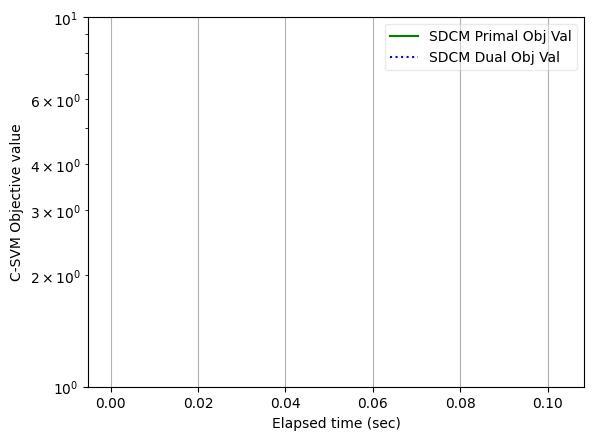

In [7]:
primal_SDCM = [obj_SDCM[i][0] for i in range(len(obj_SDCM))]
dual_SDCM = [obj_SDCM[i][1] for i in range(len(obj_SDCM))]
plt.semilogy( time_SDCM, primal_SDCM, color = 'g', linestyle = '-', label = "SDCM Primal Obj Val" )
plt.semilogy( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.legend( framealpha = 0.4 )
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.grid()
plt.show()

In [8]:
w = w_SDCM
b = b_SDCM

y_t_pred = mySVM( X_t )

y_t_pred = np.where( y_t_pred > 0, 1, -1 )

print( np.average( y_t == y_t_pred ) )

0.3509090909090909
